In [1]:
"""
Python script to generate a zero-offset synthetic from a 3-layer wedge model.

Modified from: Wes Hamlyn (https://github.com/seg/tutorials-2014/blob/master/1412_Tuning_and_AVO/tuning_wedge.py)
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
###########################################################
#
#       FUNCTIONS DEFINITIONS
#

def plot_vawig(axhdl, data, t, excursion, highlight=None):

    import numpy as np
    import matplotlib.pyplot as plt

    [ntrc, nsamp] = data.shape
    

    
    
    t = np.hstack([0, t, t.max()])
    
    for i in range(0, ntrc):
        tbuf = excursion * data[i] / np.max(np.abs(data)) + i
        
        tbuf = np.hstack([i, tbuf, i])
            
        if i==highlight:
            lw = 2
        else:
            lw = 0.5

        axhdl.plot(tbuf, t, color='black', linewidth=lw)

        plt.fill_betweenx(t, tbuf, i, where=tbuf>i, facecolor=[1.0,0.7,0.7], linewidth=0)
        plt.fill_betweenx(t, tbuf, i, where=tbuf<i, facecolor=[0.6,0.6,1.0], linewidth=0)
    
    
    axhdl.set_xlim((-excursion, ntrc+excursion))
    axhdl.xaxis.tick_top()
    axhdl.xaxis.set_label_position('top')
    axhdl.invert_yaxis()
    
  
    
def ricker(cfreq, phase, dt, wvlt_length):
    '''
    Calculate a zero-phase ricker wavelet
    
    Usage:
    ------
    t, wvlt = wvlt_ricker(cfreq, dt, wvlt_length)
    
    cfreq: central frequency of wavelet in Hz
    phase: wavelet phase in degrees
    dt: sample rate in seconds
    wvlt_length: length of wavelet in seconds
    '''
    
    import numpy as np
    import scipy.signal as signal
    
    nsamp = int(wvlt_length/dt + 1)
    t_max = wvlt_length*0.5
    t_min = -t_max
    
    t = np.arange(t_min, t_max, dt)
    
#     t = np.linspace(-wvlt_length/2, (wvlt_length-dt)/2, wvlt_length/dt)
    wvlt = (1.0 - 2.0*(np.pi**2)*(cfreq**2)*(t**2)) * np.exp(-(np.pi**2)*(cfreq**2)*(t**2))
    
    if phase != 0:
        phase = phase*np.pi/180.0
        wvlth = signal.hilbert(wvlt)
        wvlth = np.imag(wvlth)
        wvlt = np.cos(phase)*wvlt - np.sin(phase)*wvlth
    
    return t, wvlt



def calc_rc(vp_mod, rho_mod):
    '''
    rc_int = calc_rc(vp_mod, rho_mod)
    '''
    
    nlayers = len(vp_mod)
    nint = nlayers - 1
    
    rc_int = []
    for i in range(0, nint):
        buf1 = vp_mod[i+1]*rho_mod[i+1]-vp_mod[i]*rho_mod[i]
        buf2 = vp_mod[i+1]*rho_mod[i+1]+vp_mod[i]*rho_mod[i]
        buf3 = buf1/buf2
        rc_int.append(buf3)
    
    return rc_int
    
    

def calc_times(z_int, vp_mod):
    '''
    t_int = calc_times(z_int, vp_mod)
    '''
    
    nlayers = len(vp_mod)
    nint = nlayers - 1

    t_int = []
    for i in range(0, nint):
        if i == 0:
            tbuf = z_int[i]/vp_mod[i]
            t_int.append(tbuf)
        else:
            zdiff = z_int[i]-z_int[i-1]
            tbuf = 2*zdiff/vp_mod[i] + t_int[i-1]
            t_int.append(tbuf)
    
    return t_int



def digitize_model(rc_int, t_int, t):
    '''
    rc = digitize_model(rc, t_int, t)
    
    rc = reflection coefficients corresponding to interface times
    t_int = interface times
    t = regularly sampled time series defining model sampling
    '''
    
    import numpy as np
    
    nlayers = len(rc_int)
    nint = nlayers - 1
    nsamp = len(t)
    
    rc = list(np.zeros(nsamp,dtype='float'))
    lyr = 0
    
    for i in range(0, nsamp):

        if t[i] >= t_int[lyr]:
            rc[i] = rc_int[lyr]
            lyr = lyr + 1    

        if lyr > nint:
            break
            
    return rc

### Tuning wedge model
## Fig. 3

In [3]:
##       DEFINE MODELING PARAMETERS HERE

#   3-Layer Model Parameters [Layer1, Layer2, Layer 3]
vp_mod = [3500.0, 5550.0, 3500.0]  # P-wave velocity (m/s)
vs_mod = [1750.0, 2775.0, 1750.0]  # S-wave velocity (m/s)
rho_mod= [2.4, 3, 2.4]         # Density (g/cc)

dz_min = 0.0   # Minimum thickness of Layer 2 (m)
dz_max = 100.0  # Maximum thickness of Layer 2 (m)
dz_step= 1.0   # Thickness step from trace-to-trace (normally 1.0 m)

#   Ricker Wavelet Parameters
wvlt_length= 0.128
wvlt_cfreq = 30.0
wvlt_phase = 0.0

#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality

#   Plot Parameters
min_plot_time = 0.11
max_plot_time = 0.21
excursion = 2

In [4]:
#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nmodel = int((dz_max-dz_min)/dz_step+1)

#   Generate ricker wavelet
wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)

#   Calculate reflectivities from model parameters
rc_int = calc_rc(vp_mod, rho_mod)


## model
syn_zo = []
rc_zo = []
lyr_times = []
for model in range(0, nmodel):
    
    #   Calculate interface depths
    z_int = [500.0]
    z_int.append(z_int[0]+dz_min+dz_step*model)
    
    #   Calculate interface times
    t_int = calc_times(z_int, vp_mod)
    lyr_times.append(t_int)
    
    #   Digitize 3-layer model
    nsamp = int((tmax-tmin)/dt) + 1
    t = []
    for i in range(0,nsamp):
        t.append(i*dt)
        
    rc = digitize_model(rc_int, t_int, t)
    rc_zo.append(rc)
    
    #   Convolve wavelet with reflectivities
    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
    syn_buf = list(syn_buf)
    syn_zo.append(syn_buf)
    
syn_zo = np.array(syn_zo)
t = np.array(t)
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')

# Use the transpose because rows are traces;
# columns are time samples.
tuning_trace = np.argmax(np.abs(syn_zo.T)) % syn_zo.T.shape[1]
tuning_thickness = tuning_trace * dz_step

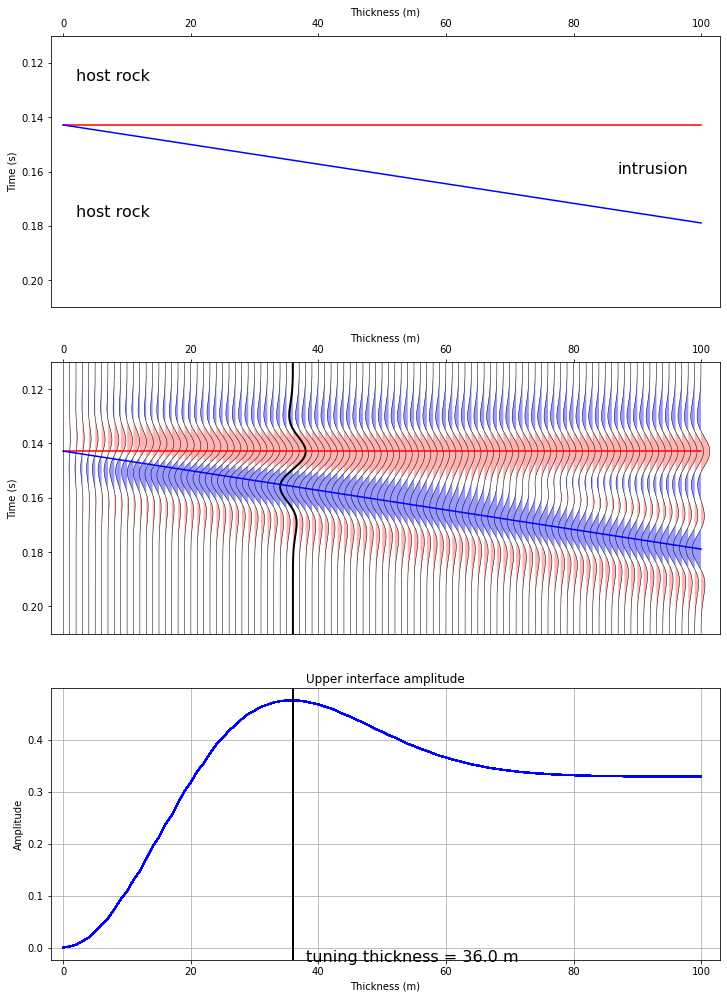

In [5]:
## Plot data

[ntrc, nsamp] = syn_zo.shape

fig = plt.figure(figsize=(12,17))#(3.54, 8))
fig.set_facecolor('white')

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

ax0 = fig.add_subplot(gs[0])
ax0.plot(lyr_times[:,0], color='red', lw=1.5)
ax0.plot(lyr_times[:,1], color='blue', lw=1.5)
ax0.set_ylim((min_plot_time,max_plot_time))
ax0.invert_yaxis()
ax0.set_xlabel('Thickness (m)')
ax0.set_ylabel('Time (s)')
plt.text(2,
        min_plot_time + (lyr_times[0,0] - min_plot_time)/2.,
        'host rock',
        fontsize=16)
plt.text(dz_max/dz_step - 2,
        lyr_times[-1,0] + (lyr_times[-1,1] - lyr_times[-1,0])/2.,
        'intrusion',
        fontsize=16,
        horizontalalignment='right')
plt.text(2,
        lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2.,
        'host rock',
        fontsize=16)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
ax0.set_xlim((-excursion, ntrc+excursion))

ax1 = fig.add_subplot(gs[1])
plot_vawig(ax1, syn_zo, t, excursion, highlight=tuning_trace)
ax1.plot(lyr_times[:,0], color='red', lw=1.5)
ax1.plot(lyr_times[:,1], color='blue', lw=1.5)
ax1.set_ylim((min_plot_time,max_plot_time))
ax1.invert_yaxis()
ax1.set_xlabel('Thickness (m)')
ax1.set_ylabel('Time (s)')

ax2 = fig.add_subplot(gs[2])
ax2.plot(syn_zo[:,lyr_indx[:,0]], color='blue')
ax2.set_xlim((-excursion, ntrc+excursion))
ax2.axvline(tuning_trace, color='k', lw=2)
ax2.grid()
ax2.set_title('Upper interface amplitude')
ax2.set_xlabel('Thickness (m)')
ax2.set_ylabel('Amplitude')
plt.text(tuning_trace + 2,
        plt.ylim()[0] * 1.1,
        'tuning thickness = {0} m'.format(str(tuning_thickness)),
        fontsize=16)

plt.show()

# Tuning wedge model based on Well-data in Glencoe 3D
## Fig. 9D

In [6]:
##       DEFINE MODELING PARAMETERS HERE

# based on Hijinx well log
vp_host = 3000  # 3000 to 3400 [m/s]
vs_host = 2100  # 1800 to 2100 [m/s]
rho_host= 2.3

vp_sill = 5550  # after Planke et al., 1999
vp_vs   = 2
vs_sill = vp_sill/vp_vs
rho_sill= 2.7

#   3-Layer Model Parameters [Layer1, Layer2, Layer 3]
vp_mod = [vp_host, vp_sill, vp_host]  # P-wave velocity (m/s)
vs_mod = [vs_host, vs_sill, vs_host]  # S-wave velocity (m/s)
rho_mod= [rho_host, rho_sill, rho_host]           # Density (g/cc)

dz_min = 0.0   # Minimum thickness of Layer 2 (m)
dz_max = 100.0  # Maximum thickness of Layer 2 (m)
dz_step= 1.0   # Thickness step from trace-to-trace (normally 1.0 m)

#   Ricker Wavelet Parameters
wvlt_length= 0.224
wvlt_cfreq = 25
wvlt_phase = 0.0

#   Trace Parameters
tmin = 0.0
tmax = 0.5
dt = 0.0001 # changing this from 0.0001 can affect the display quality

#   Plot Parameters
min_plot_time = 0.15
max_plot_time = 0.25
excursion = 2

In [7]:
#   Some handy constants
nlayers = len(vp_mod)
nint = nlayers - 1
nmodel = int((dz_max-dz_min)/dz_step+1)

#   Generate ricker wavelet
wvlt_t, wvlt_amp = ricker(wvlt_cfreq, wvlt_phase, dt, wvlt_length)

#   Calculate reflectivities from model parameters
rc_int = calc_rc(vp_mod, rho_mod)


## model
syn_zo = []
rc_zo = []
lyr_times = []
for model in range(0, nmodel):
    
    #   Calculate interface depths
    z_int = [500.0]
    z_int.append(z_int[0]+dz_min+dz_step*model)
    
    #   Calculate interface times
    t_int = calc_times(z_int, vp_mod)
    lyr_times.append(t_int)
    
    #   Digitize 3-layer model
    nsamp = int((tmax-tmin)/dt) + 1
    t = []
    for i in range(0,nsamp):
        t.append(i*dt)
        
    rc = digitize_model(rc_int, t_int, t)
    rc_zo.append(rc)
    
    #   Convolve wavelet with reflectivities
    syn_buf = np.convolve(rc, wvlt_amp, mode='same')
    syn_buf = list(syn_buf)
    syn_zo.append(syn_buf)
    
syn_zo = np.array(syn_zo)
t = np.array(t)
lyr_times = np.array(lyr_times)
lyr_indx = np.array(np.round(lyr_times/dt), dtype='int16')

# Use the transpose because rows are traces;
# columns are time samples.
tuning_trace = np.argmax(np.abs(syn_zo.T)) % syn_zo.T.shape[1]
tuning_thickness = tuning_trace * dz_step

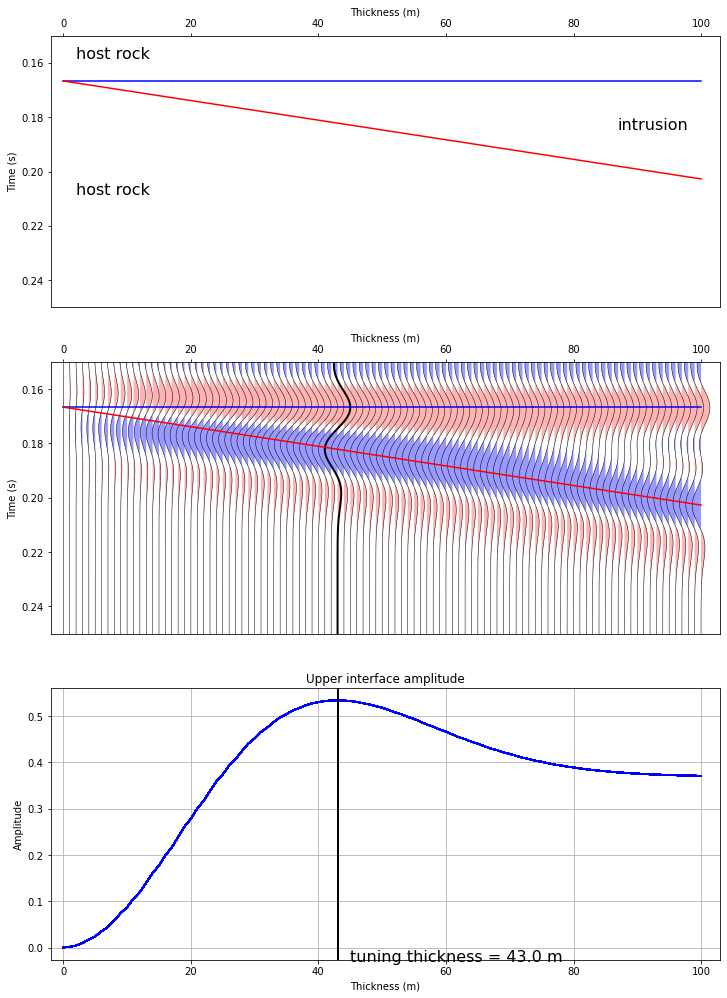

In [8]:
## Plot data

[ntrc, nsamp] = syn_zo.shape

fig = plt.figure(figsize=(12,17))#(3.54, 8))
fig.set_facecolor('white')

gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])

ax0 = fig.add_subplot(gs[0])
ax0.plot(lyr_times[:,0], color='blue', lw=1.5)
ax0.plot(lyr_times[:,1], color='red', lw=1.5)
ax0.set_ylim((min_plot_time,max_plot_time))
ax0.invert_yaxis()
ax0.set_xlabel('Thickness (m)')
ax0.set_ylabel('Time (s)')
plt.text(2,
        min_plot_time + (lyr_times[0,0] - min_plot_time)/2.,
        'host rock',
        fontsize=16)
plt.text(dz_max/dz_step - 2,
        lyr_times[-1,0] + (lyr_times[-1,1] - lyr_times[-1,0])/2.,
        'intrusion',
        fontsize=16,
        horizontalalignment='right')
plt.text(2,
        lyr_times[0,0] + (max_plot_time - lyr_times[0,0])/2.,
        'host rock',
        fontsize=16)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
ax0.set_xlim((-excursion, ntrc+excursion))

ax1 = fig.add_subplot(gs[1])
plot_vawig(ax1, syn_zo, t, excursion, highlight=tuning_trace)
ax1.plot(lyr_times[:,0], color='blue', lw=1.5)
ax1.plot(lyr_times[:,1], color='red', lw=1.5)
ax1.set_ylim((min_plot_time,max_plot_time))
ax1.invert_yaxis()
ax1.set_xlabel('Thickness (m)')
ax1.set_ylabel('Time (s)')

ax2 = fig.add_subplot(gs[2])
ax2.plot(syn_zo[:,lyr_indx[:,0]], color='blue')
ax2.set_xlim((-excursion, ntrc+excursion))
ax2.axvline(tuning_trace, color='k', lw=2)
ax2.grid()
ax2.set_title('Upper interface amplitude')
ax2.set_xlabel('Thickness (m)')
ax2.set_ylabel('Amplitude')
plt.text(tuning_trace + 2,
        plt.ylim()[0] * 1.1,
        'tuning thickness = {0} m'.format(str(tuning_thickness)),
        fontsize=16)

plt.show()